# <center> Two Day Hands-on Workshop on Machine Learning Approaches in Bacterial Genomics</center>
# <center> Conducted by DBT-BIC at SASTRA University
 <center> This work was supported by DBT grant BT/PR40144/BTIS/137/46/2022. Users are requested to acknowledge this grant when utilizing this resource </center>

## <u><center> Gene Based AMR Phenotype Prediction for Tigecycline Resistance </center></u>

###  This notebook predicts the tigecycline resistant and susceptible phenotype for <i> acinetobacter baumannii</i> isolates collected from public databases using AMR genes. It uses five different machine learning models such as Logistic Regression, Decision Tree, Random Forest, Support Vector Machine and eXtreme Gradiant Boosting. The hyper parameters of the models are tunied using Grid Search and evaluated using confusion matrix and classification report

In [1]:
# Load the necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import xgboost as xgb
from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Setting random seed for reproducibility

np.random.seed(42)

# AMR Gene Data Preprocessing

In [3]:
#Read the abricate output and the label data file in a variable

genes=pd.read_csv("AB_Abricate_summary.tab",delimiter="\t")
Label=pd.read_csv("Label_AB1.csv")

In [4]:
#Visualize the loaded data

genes.head()

,#FILE,NUM_FOUND,AAC(3)-IId,AAC(3)-IIe,AAC(3)-Ia,AAC(6')-Ian,AAC(6')-Ib7,ADC-10,ADC-25,ADC-30,...,catI,dfrA16,floR,mphE,msrE,sul1,sul2,tet(39),tet(A),tet(B)
0,1398943.3.fna.tab,29,.,.,.,.,100.00,.,.,.,...,.,.,.,100.00,100.00,100.00,.,.,.,99.50
1,1398944.3.fna.tab,29,.,100.00,.,.,.,.,100.00,.,...,.,.,.,100.00,100.00,.,100.00,.,.,99.50
2,1398948.3.fna.tab,31,.,.,.,.,100.00,.,.,100.00,...,.,.,.,100.00,100.00,100.00,.,.,.,99.50
3,1398951.3.fna.tab,31,.,100.00,.,100.00,.,.,.,.,...,.,.,.,100.00,100.00,100.00,100.00,.,.,.
4,1398956.3.fna.tab,32,.,.,.,.,100.00,.,.,100.00,...,.,.,.,100.00,100.00,100.00,.,.,.,99.50


In [5]:
Label.head()

,#FILE,Class
0,1398951.3.fna.tab,0
1,1398956.3.fna.tab,0
2,1398984.3.fna.tab,0
3,470.1320.fna.tab,0
4,470.1321.fna.tab,0


In [6]:
#Remove the unwanted column

num_found=genes.pop("NUM_FOUND")

In [7]:
# Converting the loaded data into presence absence matrix

genes.iloc[:, 1:] = genes.iloc[:, 1:].replace(".", 0)
genes.iloc[:, 1:] = (genes.iloc[:, 1:] != 0).astype(int)

In [8]:
# verify the converted data by visualizing few records

genes.head()

,#FILE,AAC(3)-IId,AAC(3)-IIe,AAC(3)-Ia,AAC(6')-Ian,AAC(6')-Ib7,ADC-10,ADC-25,ADC-30,ADC-56,...,catI,dfrA16,floR,mphE,msrE,sul1,sul2,tet(39),tet(A),tet(B)
0,1398943.3.fna.tab,0,0,0,0,1,0,0,0,1,...,0,0,0,1,1,1,0,0,0,1
1,1398944.3.fna.tab,0,1,0,0,0,0,1,0,0,...,0,0,0,1,1,0,1,0,0,1
2,1398948.3.fna.tab,0,0,0,0,1,0,0,1,0,...,0,0,0,1,1,1,0,0,0,1
3,1398951.3.fna.tab,0,1,0,1,0,0,0,0,0,...,0,0,0,1,1,1,1,0,0,0
4,1398956.3.fna.tab,0,0,0,0,1,0,0,1,0,...,0,0,0,1,1,1,0,0,0,1


In [9]:
#  Combine the AMR gene file with its Label file using merge funtion in pandas

Combined_gene_file_with_phenotype=pd.merge(genes,Label,on="#FILE")

In [10]:
# check the shape of the newly created dataframe to keep track of the columns

Combined_gene_file_with_phenotype.shape

(45, 67)

In [11]:
# Visualize the head records of the newly created file

Combined_gene_file_with_phenotype.head()

,#FILE,AAC(3)-IId,AAC(3)-IIe,AAC(3)-Ia,AAC(6')-Ian,AAC(6')-Ib7,ADC-10,ADC-25,ADC-30,ADC-56,...,dfrA16,floR,mphE,msrE,sul1,sul2,tet(39),tet(A),tet(B),Class
0,1398943.3.fna.tab,0,0,0,0,1,0,0,0,1,...,0,0,1,1,1,0,0,0,1,1
1,1398944.3.fna.tab,0,1,0,0,0,0,1,0,0,...,0,0,1,1,0,1,0,0,1,1
2,1398948.3.fna.tab,0,0,0,0,1,0,0,1,0,...,0,0,1,1,1,0,0,0,1,1
3,1398951.3.fna.tab,0,1,0,1,0,0,0,0,0,...,0,0,1,1,1,1,0,0,0,0
4,1398956.3.fna.tab,0,0,0,0,1,0,0,1,0,...,0,0,1,1,1,0,0,0,1,0


In [12]:
# Using value_counts to check the number of isolates that are present in the resistant and susceptible category

Combined_gene_file_with_phenotype.Class.value_counts()

0    25
1    20
Name: Class, dtype: int64

### Final AMR gene data after preprocessing

In [13]:
# Copy the final combined file in a variable to you it further

amr_gene_data=Combined_gene_file_with_phenotype.copy()

# Feature Selection
Feature selection is choosing relevant inputs to improve model performance, reduce complexity, and prevent overfitting by focusing on the most informative variables.

In [14]:
#This will be used further for feature selection and model building

model_data=amr_gene_data.copy() # gene data

In [15]:
#Removing the first naming column and stored in a variable called "data_df"

data_df=model_data.iloc[:,1:]

In [16]:
# View the head of the data_df

data_df.head()

,AAC(3)-IId,AAC(3)-IIe,AAC(3)-Ia,AAC(6')-Ian,AAC(6')-Ib7,ADC-10,ADC-25,ADC-30,ADC-56,ADC-6,...,dfrA16,floR,mphE,msrE,sul1,sul2,tet(39),tet(A),tet(B),Class
0,0,0,0,0,1,0,0,0,1,0,...,0,0,1,1,1,0,0,0,1,1
1,0,1,0,0,0,0,1,0,0,0,...,0,0,1,1,0,1,0,0,1,1
2,0,0,0,0,1,0,0,1,0,0,...,0,0,1,1,1,0,0,0,1,1
3,0,1,0,1,0,0,0,0,0,1,...,0,0,1,1,1,1,0,0,0,0
4,0,0,0,0,1,0,0,1,0,0,...,0,0,1,1,1,0,0,0,1,0


<h3>Now we are using two different types of Filter based methods Chi-square and Mutual information to identify the important or significant features from the loaded dataset.
Innitially start with single feature selection algorithm and later combine two or more methods depending on the problem statement and model performance</h3>

# Chi-square


The Chi-Square test is a statistical method used to determine if there is a significant association between two categorical variables. It works by comparing the observed frequencies (the actual counts from your data) with the expected frequencies (the counts you would expect if there was no relationship between the variables).

In [17]:
# To keep a note on the values that are getting generated we are creating four different list variables

columns,chi2,pval,expected=[],[],[],[]

In [18]:
"""
The below code will iterate on reach column in the dataframe excluding the target class and calculate the
chisquare contingency matrix which gives
-> chisquare statistic value
-> pvalue - significance
-> dof - degree of freedom
-> expected frequence - Based on the marginal sums of the table
"""

for i in data_df.columns[:-1]:
    contigency_tab=pd.crosstab(data_df[i],data_df['Class'])
    _chi2,_pval,_dof,_expected=chi2_contingency(contigency_tab)
    columns.append(i)
    chi2.append(_chi2)
    pval.append(_pval)
    expected.append(_expected)

In [19]:
# Converting the stored list values into a dataframe in a variable


Chisquare_test_df=pd.DataFrame([columns,chi2,pval,expected]).T

In [20]:
# Assigning column names to the newly created dataframe

Chisquare_test_df.columns=['AMR_Gene_Features','chi2','pval','expected']

In [21]:
# Extracting the items that satisfy the condition as p value < 0.05

Chisquare_df_le_05_features=Chisquare_test_df[Chisquare_test_df['pval']<=0.05]

In [22]:
print(f"The are {Chisquare_df_le_05_features.shape[0]} features that are significant in the collected feature list")

The are 26 features that are significant in the collected feature list


In [23]:
# Converting the feature names to list

signi_chisquare_selected_features=Chisquare_df_le_05_features.AMR_Gene_Features.tolist()

In [24]:
# Appending the class feature to the significant feature list

signi_chisquare_selected_features.append('Class')

In [25]:
# Extracting the significat columns from the final data

df_Chisquare_based_feature_selection=data_df[signi_chisquare_selected_features]

In [26]:
# Explore the finally created dataset after feature selection
# Use this dataset for model building

df_Chisquare_based_feature_selection.shape

(45, 27)

## Mutual Information
 * It measures how much information a feature gives about the target class.
 * It’s non-parametric: it doesn’t assume any distribution

To calculate mutual info value we need to first split the idependent and indepoendent variables and need to pass to the function

In [27]:
"""
Spliting the data_df as X and y
X holds the independent variables
y hold the dependent variable (target class)
"""

X=data_df.drop(['Class'],axis=1)
y=data_df['Class']

In [28]:
# Calling the mutual_info_classif function to perform the classification task

mi_scores = mutual_info_classif(X, y)

In [29]:
mi_df = pd.DataFrame([X.columns,mi_scores]).T # Storing in dataframe

mi_df.columns=['AMR_Gene_Features','MI_scores'] # Renaming the columns

MI_feature=mi_df[mi_df['MI_scores']>0] # Filtering the features based on a threshold value of info

MI_feature_list=MI_feature.AMR_Gene_Features.tolist() # Converting the features to a list

MI_feature_list.append('Class') # Appending the Class feature to the list

df_MI_based_feature_selection=data_df[MI_feature_list] # Extracting the selected columns

In [30]:
# Explore the finally created dataset using MI
# Use this dataset for model building

df_MI_based_feature_selection.shape

(45, 41)

<br>

# Data Train & Test split  

In [31]:
# Replace the desiered data for modelbuilding

data = df_Chisquare_based_feature_selection # df_MI_based_feature_selection.copy()

In [32]:
# Splitting the data as X and y

X=data.drop(["Class"],axis=1).astype(int)
y=data["Class"].astype(int)

In [33]:
"""
-> Here we are splitting the dataset for training and testing
-> random_state is assigned for reproducibility
-> statify variable is to split the Class variables to equal ratio in the train and test dataset
"""

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=42,stratify=y)

In [34]:
print('Number of rows and columns of the training set for the independent variables:',X_train.shape)
print('Number of rows and columns of the training set for the dependent variable:',y_train.shape)
print('Number of rows and columns of the test set for the independent variables:',X_test.shape)
print('Number of rows and columns of the test set for the dependent variable:',y_test.shape)

Number of rows and columns of the training set for the independent variables: (36, 26)
Number of rows and columns of the training set for the dependent variable: (36,)
Number of rows and columns of the test set for the independent variables: (9, 26)
Number of rows and columns of the test set for the dependent variable: (9,)


# Model building, Hyper parameter tuning and Model evaluation

## Logistic Regression

Logistic Regression is a supervised classification algorithm that models the probability of a categorical outcome (often binary) using a logistic (sigmoid) function applied to a linear combination of input features


## Hyper parameter tuning for Logistic Regression

In [35]:
# In order to tune the hyper parameters we are using this grid search and finding the best estimator
grid={"solver":["newton-cg","lbfgs","sag","saga"],
    "C":np.arange(0.01,1,0.1),
    "max_iter":np.arange(1,10,2)
     }

model = LogisticRegression(random_state=42)

grid_search = GridSearchCV(estimator = model, param_grid = grid, cv = 5)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_,'\n')
print(grid_search.best_estimator_)

{'C': 0.81, 'max_iter': 7, 'solver': 'sag'} 

LogisticRegression(C=0.81, max_iter=7, random_state=42, solver='sag')


## Comparison between model with and without tuning

In [36]:
lr_without = LogisticRegression(random_state=42)
lr_with = LogisticRegression(C=0.81, max_iter=7, solver="sag",random_state=42)

models=[lr_without,lr_with]

scores_train=[]
scores_test=[]

for i in models:
    i.fit(X_train,y_train)
    scores_train.append(i.score(X_train,y_train))
    scores_test.append(i.score(X_test,y_test))

print(pd.DataFrame({'Train Accuracy':scores_train,'Test accuracy':scores_test},index=['without_hyper','with_hyper']))

               Train Accuracy  Test accuracy
without_hyper        0.944444            1.0
with_hyper           0.944444            1.0


## Prediction using final tuned model

In [37]:
logmodel = LogisticRegression(C=0.81, max_iter=7, solver="sag",random_state=42)
logmodel.fit(X_train, y_train)

log_ytrain_predict = logmodel.predict(X_train)
log_ytest_predict = logmodel.predict(X_test)

# <center> Model evaluation </center>

# Confusion Matrix
A confusion matrix is a 2D table that shows how well a classification model performs by comparing the actual labels with the predicted labels.

Rows usually = Actual values

Columns usually = Predicted values

<table>
  <tr>
    <th></th>
    <th>Predicted Positive</th>
    <th>Predicted Negative</th>
  </tr>
  <tr>
    <th>Actual Positive</th>
    <td>True Positive (TP)</td>
    <td>False Negative (FN)</td>
  </tr>
  <tr>
    <th>Actual Negative</th>
    <td>False Positive (FP)</td>
    <td>True Negative (TN)</td>
  </tr>
</table>


True Positive (TP) → Model correctly predicted positive.

True Negative (TN) → Model correctly predicted negative.

False Positive (FP) → Model predicted positive but it was actually negative (Type I error).

False Negative (FN) → Model predicted negative but it was actually positive (Type II error).

<b> Confusion Matrix is the base tool to judge a classifier — it shows the counts of correct and incorrect predictions, from which all other classification metrics are derived.</b>

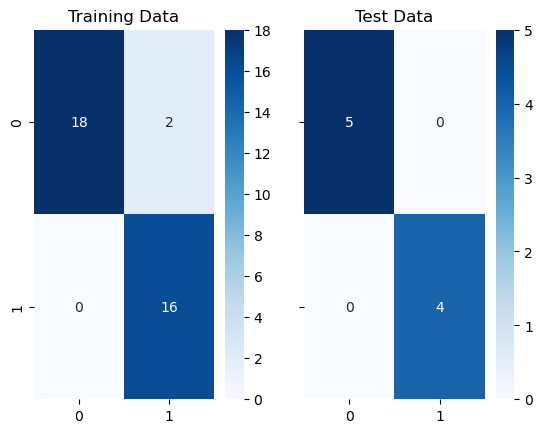

In [38]:
f,a =  plt.subplots(1,2,sharex=True,sharey=True,squeeze=False)

plot_0 = sns.heatmap((confusion_matrix(y_train,log_ytrain_predict)),annot=True,fmt='.5g',cmap='Blues',ax=a[0][0]);
a[0][0].set_title('Training Data')

plot_1 = sns.heatmap((confusion_matrix(y_test,log_ytest_predict)),annot=True,fmt='.5g',cmap='Blues',ax=a[0][1]);
a[0][1].set_title('Test Data');


## <center> Classification metrics </center>

Classification metrics are quantitative measures we use to evaluate how well a classification model is performing. They go beyond just accuracy and give us detailed insights into the types of errors the model makes.
These metrics are usually derived from the confusion matrix.

<b>Accuracy</b> - Good when classes are balanced, but misleading when classes are imbalanced.
<b>(TP + TN) / (TP + TN + FP + FN)</b>

<b>Precision (Positive Predictive Value) </b>- Important when false positives are costly for the predicted positive group.  <b>TP / (TP + FP)</b>

<b>Recall (Sensitivity / True Positive Rate) </b>- Important when the cost of a false negative is high. <b>TP / (TP + FN)</b>

<b>F1-Score</b> - Useful when you need a balance between precision and recall. <b>2 &times; (Precision &times; Recall) / (Precision + Recall)</b>

<b>Specificity (True Negative Rate) </b>- Important when false positives are costly for the actual negative group. <b>TN / (TN + FP)</b>


<b> Classification metrics give us a complete picture of how well a model performs, where it succeeds, and where it fails. </b>

In [39]:
print('Classification Report of the training data:\n\n',classification_report(y_train,log_ytrain_predict),'\n')
print('Classification Report of the test data:\n\n',classification_report(y_test,log_ytest_predict),'\n')

Classification Report of the training data:

               precision    recall  f1-score   support

           0       1.00      0.90      0.95        20
           1       0.89      1.00      0.94        16

    accuracy                           0.94        36
   macro avg       0.94      0.95      0.94        36
weighted avg       0.95      0.94      0.94        36
 

Classification Report of the test data:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9
 



AUC for the Training Data: 0.981
AUC for the Test Data: 1.000


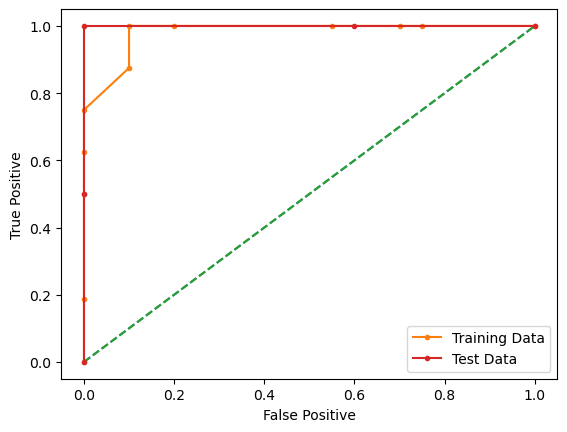

In [40]:
# AUC and ROC for the training data

# calculate AUC
probs = logmodel.predict_proba(X_train)

auc = roc_auc_score(y_train,probs[:,1])
print('AUC for the Training Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(y_train,probs[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label = 'Training Data')


# AUC and ROC for the test data
probs = logmodel.predict_proba(X_test)

# calculate AUC
auc = roc_auc_score(y_test,probs[:,1])
print('AUC for the Test Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test,probs[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')

# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label='Test Data')
# show the plot
plt.legend(loc='best')
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.show()

### Storing the coefficient of the model to a csv file

In [41]:
log_fea_imp=pd.DataFrame([logmodel.feature_names_in_,logmodel.coef_]).T
log_fea_imp.columns=['AMR_Gene_Features','Coef']
log_fea_imp.sort_values(by='Coef',ascending=False,inplace=True)
log_fea_imp.to_csv("Feature_importance_AMR_Gene_Model_LR.csv",index=False)

# Decision Tree

A Decision Tree is a supervised machine learning algorithm used for both classification and regression tasks. It models decisions based on a series of simple, conditional rules, much like a flowchart

## Hyper parameter tuning for Decision Tree

In [42]:
grid={
    'max_depth': np.arange(1, 5), # depth of the tree
    'min_samples_split': np.arange(3, 5), # minimum samples required to split an internal node
    'min_samples_leaf': np.arange(2, 6), # minimum samples required to be at a leaf node
    'criterion':['gini', 'entropy', 'log_loss']
     }

model = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator = model, param_grid = grid, cv = 5)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_,'\n')
print(grid_search.best_estimator_)

{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 3} 

DecisionTreeClassifier(max_depth=2, min_samples_leaf=2, min_samples_split=3,
                       random_state=42)


In [43]:
DT_without = DecisionTreeClassifier(random_state=42)
DT_with = DecisionTreeClassifier(random_state=42, criterion='gini',max_depth=2, 
                                 min_samples_leaf=2,min_samples_split=3)


models=[DT_without,DT_with]

scores_train=[]
scores_test=[]

for i in models:
    i.fit(X_train,y_train)
    scores_train.append(i.score(X_train,y_train))
    scores_test.append(i.score(X_test,y_test))

print(pd.DataFrame({'Train Accuracy':scores_train,'Test accuracy':scores_test},index=['without_hyper','with_hyper']))

               Train Accuracy  Test accuracy
without_hyper        0.944444       0.777778
with_hyper           0.916667       0.777778


In [44]:
DTmodel = DecisionTreeClassifier(random_state=42, criterion='gini',max_depth=2, 
                                 min_samples_leaf=2,min_samples_split=3)
DTmodel.fit(X_train, y_train)

DT_ytrain_predict = DTmodel.predict(X_train)
DT_ytest_predict = DTmodel.predict(X_test)

## To visualize the tree we are creating a dot file using the generated decision tree model

Pasting the contents of the generated dot file at  http://webgraphviz.com/

In [45]:
# Visualize the class variables

DTmodel.classes_

array([0, 1])

In [46]:
from sklearn import tree
train_char_label = ['Sus', 'Res']
Tree_File = open('visualize_tree.dot','w')
dot_data = tree.export_graphviz(DTmodel, out_file=Tree_File, feature_names = list(X_train), class_names = list(train_char_label))
Tree_File.close()

## Confusion Matrix

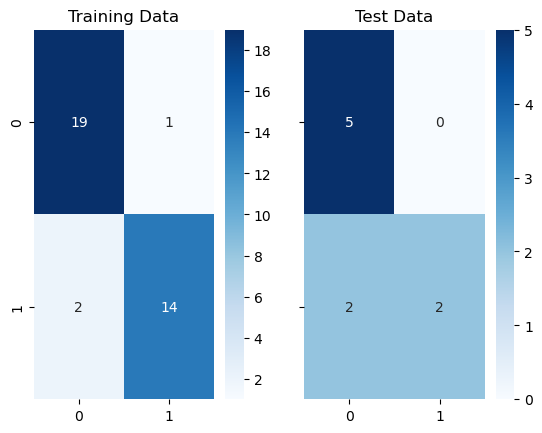

In [47]:
f,a =  plt.subplots(1,2,sharex=True,sharey=True,squeeze=False)

plot_0 = sns.heatmap((confusion_matrix(y_train,DT_ytrain_predict)),annot=True,fmt='.5g',cmap='Blues',ax=a[0][0]);
a[0][0].set_title('Training Data')

plot_1 = sns.heatmap((confusion_matrix(y_test,DT_ytest_predict)),annot=True,fmt='.5g',cmap='Blues',ax=a[0][1]);
a[0][1].set_title('Test Data');


## Classification report

In [48]:
print('Classification Report of the training data:\n\n',classification_report(y_train,DT_ytrain_predict),'\n')
print('Classification Report of the test data:\n\n',classification_report(y_test,DT_ytest_predict),'\n')

Classification Report of the training data:

               precision    recall  f1-score   support

           0       0.90      0.95      0.93        20
           1       0.93      0.88      0.90        16

    accuracy                           0.92        36
   macro avg       0.92      0.91      0.92        36
weighted avg       0.92      0.92      0.92        36
 

Classification Report of the test data:

               precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.50      0.67         4

    accuracy                           0.78         9
   macro avg       0.86      0.75      0.75         9
weighted avg       0.84      0.78      0.76         9
 



AUC for the Training Data: 0.956
AUC for the Test Data: 1.000


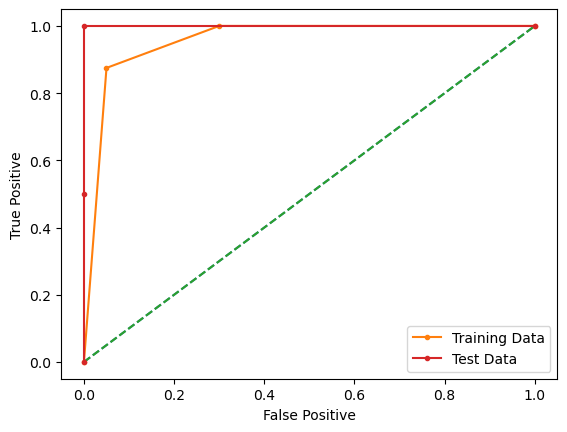

In [49]:
# AUC and ROC for the training data

# calculate AUC
probs = DTmodel.predict_proba(X_train)

auc = roc_auc_score(y_train,probs[:,1])
print('AUC for the Training Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(y_train,probs[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label = 'Training Data')


# AUC and ROC for the test data
probs = DTmodel.predict_proba(X_test)

# calculate AUC
auc = roc_auc_score(y_test,probs[:,1])
print('AUC for the Test Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test,probs[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label='Test Data')
# show the plot
plt.legend(loc='best')
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.show()

### Storing the featue importance of decision tree in csv file

In [50]:
DT_fea_imp=pd.DataFrame([DTmodel.feature_names_in_,DTmodel.feature_importances_]).T
DT_fea_imp.columns=['AMR_Gene_Features','Feature_importance']
DT_fea_imp.sort_values(by='Feature_importance',ascending=False,inplace=True)
DT_fea_imp.to_csv("Feature_importance_AMR_Gene_Model_DT.csv",index=False)

# Random Forest

Random Forest is an ensemble learning algorithm that builds multiple decision trees on random subsets of data and features, then combines their outputs (by majority vote or averaging) to improve accuracy and reduce overfitting

## Hyper parameter tuning for Random forest

In [51]:
grid={
     'criterion':['gini', 'entropy', 'log_loss'],
     'n_estimators':np.arange(5,10),
     'max_depth':np.arange(5,10)
     }

model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator = model, param_grid = grid, cv = 5)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_,'\n')
print(grid_search.best_estimator_)

{'criterion': 'gini', 'max_depth': 6, 'n_estimators': 5} 

RandomForestClassifier(max_depth=6, n_estimators=5, random_state=42)


In [52]:
RF_without = RandomForestClassifier(random_state=42)
RF_with = RandomForestClassifier(random_state=42, criterion='gini',max_depth=6, n_estimators=5)


models=[RF_without,RF_with]

scores_train=[]
scores_test=[]

for i in models:
    i.fit(X_train,y_train)
    scores_train.append(i.score(X_train,y_train))
    scores_test.append(i.score(X_test,y_test))

print(pd.DataFrame({'Train Accuracy':scores_train,'Test accuracy':scores_test},index=['without_hyper','with_hyper']))

               Train Accuracy  Test accuracy
without_hyper        0.944444       1.000000
with_hyper           0.944444       0.777778


In [53]:
RFmodel = RandomForestClassifier(random_state=42, criterion='gini',max_depth=6, n_estimators=5)
RFmodel.fit(X_train, y_train)

RF_ytrain_predict = RFmodel.predict(X_train)
RF_ytest_predict = RFmodel.predict(X_test)

## Confusion Matrix

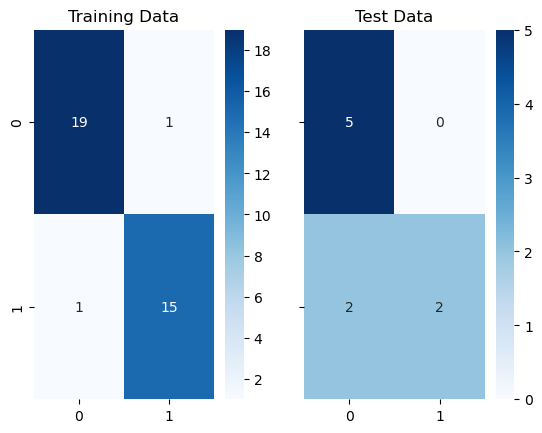

In [54]:
f,a =  plt.subplots(1,2,sharex=True,sharey=True,squeeze=False)

plot_0 = sns.heatmap((confusion_matrix(y_train,RF_ytrain_predict)),annot=True,fmt='.5g',cmap='Blues',ax=a[0][0]);
a[0][0].set_title('Training Data')

plot_1 = sns.heatmap((confusion_matrix(y_test,RF_ytest_predict)),annot=True,fmt='.5g',cmap='Blues',ax=a[0][1]);
a[0][1].set_title('Test Data');


## Classification Report

In [55]:
print('Classification Report of the training data:\n\n',classification_report(y_train,RF_ytrain_predict),'\n')
print('Classification Report of the test data:\n\n',classification_report(y_test,RF_ytest_predict),'\n')

Classification Report of the training data:

               precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.94      0.94      0.94        16

    accuracy                           0.94        36
   macro avg       0.94      0.94      0.94        36
weighted avg       0.94      0.94      0.94        36
 

Classification Report of the test data:

               precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.50      0.67         4

    accuracy                           0.78         9
   macro avg       0.86      0.75      0.75         9
weighted avg       0.84      0.78      0.76         9
 



AUC for the Training Data: 0.994
AUC for the Test Data: 1.000


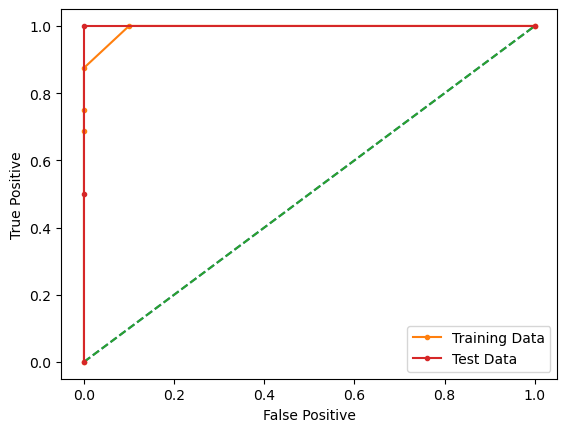

In [56]:
# AUC and ROC for the training data

# calculate AUC
probs = RFmodel.predict_proba(X_train)

auc = roc_auc_score(y_train,probs[:,1])
print('AUC for the Training Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(y_train,probs[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label = 'Training Data')


# AUC and ROC for the test data
probs = RFmodel.predict_proba(X_test)

# calculate AUC
auc = roc_auc_score(y_test,probs[:,1])
print('AUC for the Test Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test,probs[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label='Test Data')
# show the plot
plt.legend(loc='best')
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.show()

### Storing the feature importance of the random forest in csv file

In [57]:
RF_fea_imp=pd.DataFrame([RFmodel.feature_names_in_,RFmodel.feature_importances_]).T
RF_fea_imp.columns=['AMR_Gene_Features','Feature_importance']
RF_fea_imp.sort_values(by='Feature_importance',ascending=False,inplace=True)
RF_fea_imp.to_csv("Feature_importance_AMR_Gene_Model_RF.csv",index=False)

# SVC

## Hyper parameter tuning for SVC

In [58]:
grid={'C':  np.arange(0.01,1,0.1),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
     }

model = svm.SVC(random_state=42)

grid_search = GridSearchCV(estimator = model, param_grid = grid, cv = 5)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_,'\n')
print(grid_search.best_estimator_)

{'C': 0.31000000000000005, 'kernel': 'linear'} 

SVC(C=0.31000000000000005, kernel='linear', random_state=42)


In [59]:
SVC_without = svm.SVC(random_state=42)
SVC_with = svm.SVC(C=0.3,kernel='linear',random_state=42)


models=[SVC_without,SVC_with]

scores_train=[]
scores_test=[]

for i in models:
    i.fit(X_train,y_train)
    scores_train.append(i.score(X_train,y_train))
    scores_test.append(i.score(X_test,y_test))

print(pd.DataFrame({'Train Accuracy':scores_train,'Test accuracy':scores_test},index=['without_hyper','with_hyper']))

               Train Accuracy  Test accuracy
without_hyper        0.944444       1.000000
with_hyper           0.944444       0.888889


In [60]:
SVCmodel = svm.SVC(C=0.3,kernel='linear',random_state=42,probability=True)
SVCmodel.fit(X_train, y_train)

SVC_ytrain_predict = SVCmodel.predict(X_train)
SVC_ytest_predict = SVCmodel.predict(X_test)

## Confusion Matrix

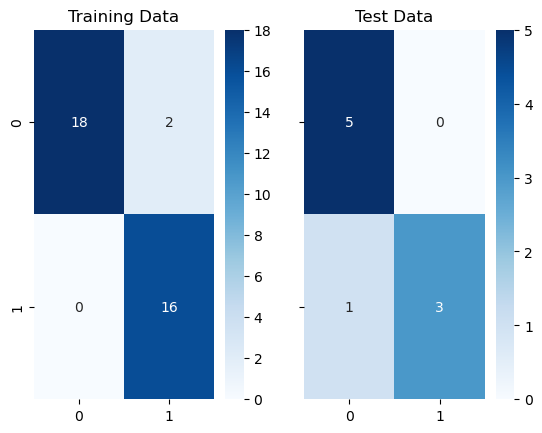

In [61]:
f,a =  plt.subplots(1,2,sharex=True,sharey=True,squeeze=False)

plot_0 = sns.heatmap((confusion_matrix(y_train,SVC_ytrain_predict)),annot=True,fmt='.5g',cmap='Blues',ax=a[0][0]);
a[0][0].set_title('Training Data')

plot_1 = sns.heatmap((confusion_matrix(y_test,SVC_ytest_predict)),annot=True,fmt='.5g',cmap='Blues',ax=a[0][1]);
a[0][1].set_title('Test Data');


## Classification Report

In [62]:
print('Classification Report of the training data:\n\n',classification_report(y_train,SVC_ytrain_predict),'\n')
print('Classification Report of the test data:\n\n',classification_report(y_test,SVC_ytest_predict),'\n')

Classification Report of the training data:

               precision    recall  f1-score   support

           0       1.00      0.90      0.95        20
           1       0.89      1.00      0.94        16

    accuracy                           0.94        36
   macro avg       0.94      0.95      0.94        36
weighted avg       0.95      0.94      0.94        36
 

Classification Report of the test data:

               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.75      0.86         4

    accuracy                           0.89         9
   macro avg       0.92      0.88      0.88         9
weighted avg       0.91      0.89      0.89         9
 



AUC for the Training Data: 0.987
AUC for the Test Data: 1.000


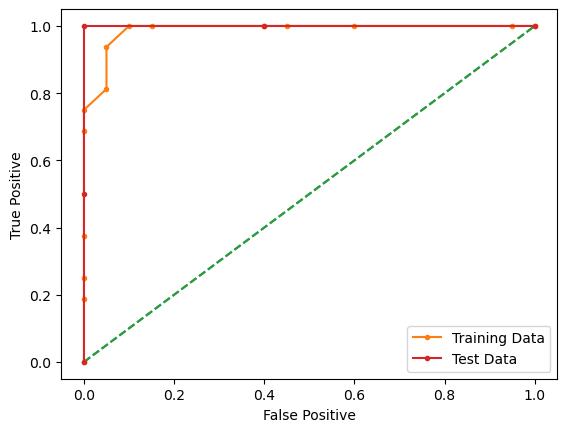

In [63]:
# AUC and ROC for the training data

# calculate AUC
probs = SVCmodel.predict_proba(X_train)

auc = roc_auc_score(y_train,probs[:,1])
print('AUC for the Training Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(y_train,probs[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label = 'Training Data')


# AUC and ROC for the test data
probs = SVCmodel.predict_proba(X_test)

# calculate AUC
auc = roc_auc_score(y_test,probs[:,1])
print('AUC for the Test Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test,probs[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label='Test Data')
# show the plot
plt.legend(loc='best')
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.show()

### Storing the coefficient of the SVC in a csv file

In [64]:
svm_coef=pd.DataFrame([SVCmodel.feature_names_in_,SVCmodel.coef_.flatten()]).T
svm_coef.head()
svm_coef.columns=['GENE','Coef']
svm_coef.sort_values(by='Coef',ascending=False,inplace=True)
svm_coef.head()
svm_coef.to_csv("Feature_importance_AMR_Gene_Model_SVM.csv",index=False)

# XGboost

## Hyper parameter tuning for Xgboost

In [65]:
grid={"learning_rate": np.arange(0.01,0.1,0.01),
    "max_depth": np.arange(3,5),
    "n_estimators":np.arange(3,5)
     }

model = xgb.XGBClassifier(random_state=42)

grid_search = GridSearchCV(estimator = model, param_grid = grid, cv = 5)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_,'\n')
print(grid_search.best_estimator_)

{'learning_rate': 0.060000000000000005, 'max_depth': 3, 'n_estimators': 4} 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.060000000000000005,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=4, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)


In [66]:
XGB_without = xgb.XGBClassifier(random_state=42)
XGB_with = xgb.XGBClassifier(learning_rate=0.06,max_depth=3,n_estimators= 4,random_state=42)


models=[XGB_without,XGB_with]

scores_train=[]
scores_test=[]

for i in models:
    i.fit(X_train,y_train)
    scores_train.append(i.score(X_train,y_train))
    scores_test.append(i.score(X_test,y_test))

print(pd.DataFrame({'Train Accuracy':scores_train,'Test accuracy':scores_test},index=['without_hyper','with_hyper']))

               Train Accuracy  Test accuracy
without_hyper        0.944444       0.888889
with_hyper           0.916667       0.777778


In [67]:
XGBmodel = xgb.XGBClassifier(learning_rate=0.06,max_depth=3,n_estimators= 4,random_state=42)
XGBmodel.fit(X_train, y_train)

XGB_ytrain_predict = XGBmodel.predict(X_train)
XGB_ytest_predict = XGBmodel.predict(X_test)

## Confusion Matrix

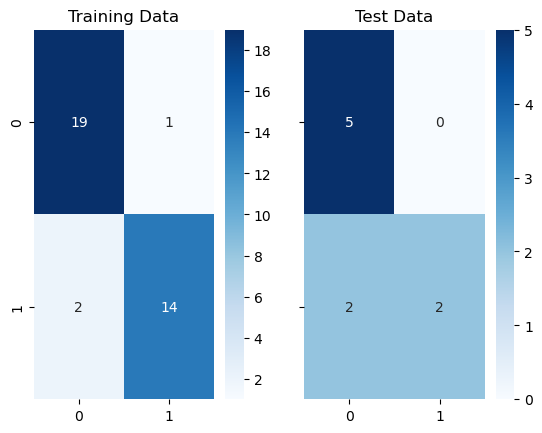

In [68]:
f,a =  plt.subplots(1,2,sharex=True,sharey=True,squeeze=False)

plot_0 = sns.heatmap((confusion_matrix(y_train,XGB_ytrain_predict)),annot=True,fmt='.5g',cmap='Blues',ax=a[0][0]);
a[0][0].set_title('Training Data')

plot_1 = sns.heatmap((confusion_matrix(y_test,XGB_ytest_predict)),annot=True,fmt='.5g',cmap='Blues',ax=a[0][1]);
a[0][1].set_title('Test Data');


## Classification Report

In [69]:
print('Classification Report of the training data:\n\n',classification_report(y_train,XGB_ytrain_predict),'\n')
print('Classification Report of the test data:\n\n',classification_report(y_test,XGB_ytest_predict),'\n')

Classification Report of the training data:

               precision    recall  f1-score   support

           0       0.90      0.95      0.93        20
           1       0.93      0.88      0.90        16

    accuracy                           0.92        36
   macro avg       0.92      0.91      0.92        36
weighted avg       0.92      0.92      0.92        36
 

Classification Report of the test data:

               precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.50      0.67         4

    accuracy                           0.78         9
   macro avg       0.86      0.75      0.75         9
weighted avg       0.84      0.78      0.76         9
 



AUC for the Training Data: 0.956
AUC for the Test Data: 1.000


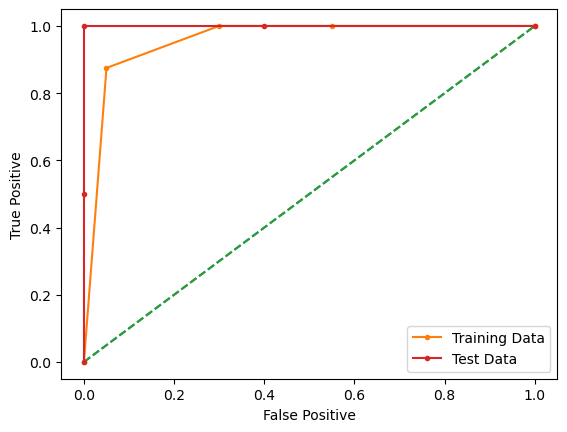

In [70]:
# AUC and ROC for the training data

# calculate AUC
probs = XGBmodel.predict_proba(X_train)

auc = roc_auc_score(y_train,probs[:,1])
print('AUC for the Training Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(y_train,probs[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label = 'Training Data')


# AUC and ROC for the test data
probs = XGBmodel.predict_proba(X_test)

# calculate AUC
auc = roc_auc_score(y_test,probs[:,1])
print('AUC for the Test Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test,probs[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label='Test Data')
# show the plot
plt.legend(loc='best')
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.show()

### Storing the coefficient of the Xgboost in a csv file

In [71]:
xgb_fea_imp=pd.DataFrame([XGBmodel.feature_names_in_,XGBmodel.feature_importances_]).T
xgb_fea_imp.columns=['AMR_Gene_Features','Feature_importance']
xgb_fea_imp.sort_values(by='Feature_importance',ascending=False,inplace=True)
xgb_fea_imp.to_csv("Feature_importance_AMR_Gene_Model_XGB.csv",index=False)

## Comparing Model Performance Based on Accuracy

Here we are creating variables which holds accuracy of both train and test dataset for five different models and visualizing the accuracies using a bar plot from matplotlib library

In [72]:
# Creating a dataframe which holds the accuracy value of train and test

train_LR=logmodel.score(X_train,y_train)
test_LR=logmodel.score(X_test,y_test)
df1=pd.DataFrame([train_LR,test_LR]).T

train_DT=DTmodel.score(X_train,y_train)
test_DT=DTmodel.score(X_test,y_test)
df2=pd.DataFrame([train_DT,test_DT]).T


train_RF=RFmodel.score(X_train,y_train)
test_RF=RFmodel.score(X_test,y_test)
df3=pd.DataFrame([train_RF,test_RF]).T

train_SVC=SVCmodel.score(X_train,y_train)
test_SVC=SVCmodel.score(X_test,y_test)
df4=pd.DataFrame([train_SVC,test_SVC]).T

train_XGB=XGBmodel.score(X_train,y_train)
test_XGB=XGBmodel.score(X_test,y_test)
df5=pd.DataFrame([train_XGB,test_XGB]).T


In [73]:
# Concatinating all the dataframes

combined_df = pd.concat([df1,df2,df3,df4,df5], ignore_index=False)

In [74]:
# Renaming the indexes and columns

combined_df.index=['LR','DT','RF','SVM','XGB']
combined_df.columns=['Train', 'Test']

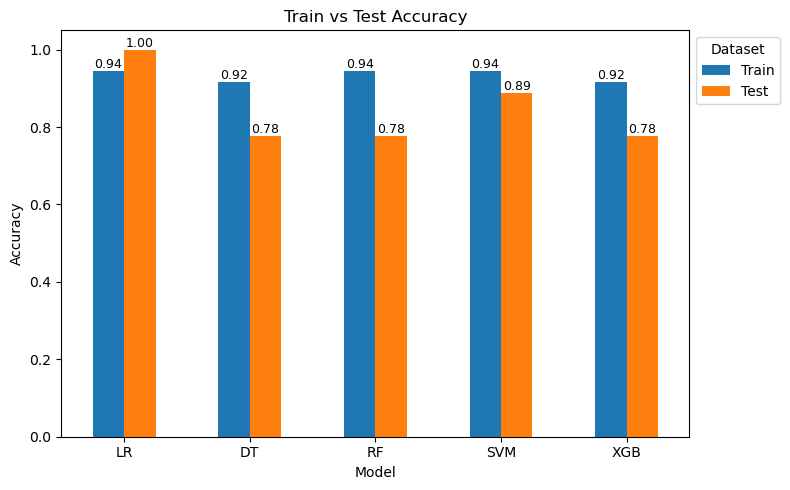

In [75]:
# Plotting the results for analysis

ax = combined_df.plot(kind="bar", figsize=(8,5))

plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.title("Train vs Test Accuracy")
plt.xticks(rotation=0)
plt.legend(title="Dataset", bbox_to_anchor=(1, 1))

# Annotate each bar with its value
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f",  fontsize=9)

plt.tight_layout()
plt.show()

On analyzing based on accuracy <b>SVM</b> model is considered to be a better performing with lower differnce in the accuracy between the training and testing data. Inconsideration with this we are obtaining the top 5 features of SVM model for biological annotation